In [48]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model

In [2]:
# load feature maps
def load_feature_maps(base_folder):
    # Initialize a dictionary with stages as keys
    feature_maps_by_stage = {
        'stage_1': {}, 'stage_2': {}, 'stage_3': {}, 'stage_4': {}, 'stage_5': {}
    }

    # List of subfolders corresponding to different stages
    stages = ['stage_1', 'stage_2', 'stage_3', 'stage_4', 'stage_5']

    # Iterate through each stage
    for stage in stages:
        stage_folder = os.path.join(base_folder, stage)
        
        # Check if the stage folder exists and is a directory
        if os.path.exists(stage_folder) and os.path.isdir(stage_folder):
            for filename in os.listdir(stage_folder):
                if filename.endswith('.pkl'):
                    # Extract video ID (first four characters of the filename)
                    video_id = filename[:4]
                    
                    # Load the feature map from the .pkl file
                    file_path = os.path.join(stage_folder, filename)
                    with open(file_path, 'rb') as file:
                        feature_map = pickle.load(file)
                    
                    # Remove the singleton dimension
                    feature_map_squeezed = np.squeeze(feature_map)
                    # Store the feature map in the dictionary under the appropriate stage and video ID
                    feature_maps_by_stage[stage][video_id] = feature_map_squeezed

    return feature_maps_by_stage

In [3]:
base_folder = 'preprocessed_videos_30frames'
feature_maps = load_feature_maps(base_folder)

In [4]:
for stage, video_features in feature_maps.items():
    print(f"{stage}:")
    
    # Get the first 5 video IDs for this stage
    first_five_videos = list(video_features.keys())[:5]
    
    for video_id in first_five_videos:
        feature_map = video_features[video_id]
        # Print the video ID and the shape of its feature map array
        print(f"  Video ID: {video_id}, Feature Map Shape: {feature_map.shape}")

stage_1:
  Video ID: 0001, Feature Map Shape: (30, 56, 56, 64)
  Video ID: 0002, Feature Map Shape: (30, 56, 56, 64)
  Video ID: 0003, Feature Map Shape: (30, 56, 56, 64)
  Video ID: 0004, Feature Map Shape: (30, 56, 56, 64)
  Video ID: 0005, Feature Map Shape: (30, 56, 56, 64)
stage_2:
  Video ID: 0001, Feature Map Shape: (30, 56, 56, 256)
  Video ID: 0002, Feature Map Shape: (30, 56, 56, 256)
  Video ID: 0003, Feature Map Shape: (30, 56, 56, 256)
  Video ID: 0004, Feature Map Shape: (30, 56, 56, 256)
  Video ID: 0005, Feature Map Shape: (30, 56, 56, 256)
stage_3:
  Video ID: 0001, Feature Map Shape: (30, 28, 28, 512)
  Video ID: 0002, Feature Map Shape: (30, 28, 28, 512)
  Video ID: 0003, Feature Map Shape: (30, 28, 28, 512)
  Video ID: 0004, Feature Map Shape: (30, 28, 28, 512)
  Video ID: 0005, Feature Map Shape: (30, 28, 28, 512)
stage_4:
  Video ID: 0001, Feature Map Shape: (30, 14, 14, 1024)
  Video ID: 0002, Feature Map Shape: (30, 14, 14, 1024)
  Video ID: 0003, Feature Map Sh

In [6]:
def pool_feature_maps(feature_maps):
    
    pooled_feature_maps = {}
    
    for stage, videos in feature_maps.items():
        pooled_feature_maps[stage] = {}
        for video_id, feature_map in videos.items():
            # Max Pooling
            # Apply max pooling over the first dimension (frames)
            max_pooled_over_frames = np.max(feature_map, axis=0)
            # Apply max pooling over the last dimension (channels)
            max_pooled_feature_map = np.max(max_pooled_over_frames, axis=-1)
            
            # Average Pooling
            # Apply average pooling over the first dimension (frames)
            avg_pooled_over_frames = np.mean(feature_map, axis=0)
            # Apply average pooling over the last dimension (channels)
            avg_pooled_feature_map = np.mean(avg_pooled_over_frames, axis=-1)
            
            # Store the results in the new dictionary
            pooled_feature_maps[stage][video_id] = {
                'avg': avg_pooled_feature_map,
                'max': max_pooled_feature_map
            }
            
    return pooled_feature_maps

In [7]:
pooled_feature_maps = pool_feature_maps(feature_maps)

In [8]:
for stage, videos in pooled_feature_maps.items():
        print(f"{stage}:")
        
        # Get the first 5 video IDs for this stage
        first_five_videos = list(videos.keys())[:5]
        
        for video_id in first_five_videos:
            # Retrieve both the averaged and max-pooled feature maps for this video
            avg_pooled_feature_map = videos[video_id]['avg']
            max_pooled_feature_map = videos[video_id]['max']
            
            # Print the video ID and the shapes of its pooled feature maps
            print(f"  Video ID: {video_id}, Avg Pooled Shape: {avg_pooled_feature_map.shape}, Max Pooled Shape: {max_pooled_feature_map.shape}")

stage_1:
  Video ID: 0001, Avg Pooled Shape: (56, 56), Max Pooled Shape: (56, 56)
  Video ID: 0002, Avg Pooled Shape: (56, 56), Max Pooled Shape: (56, 56)
  Video ID: 0003, Avg Pooled Shape: (56, 56), Max Pooled Shape: (56, 56)
  Video ID: 0004, Avg Pooled Shape: (56, 56), Max Pooled Shape: (56, 56)
  Video ID: 0005, Avg Pooled Shape: (56, 56), Max Pooled Shape: (56, 56)
stage_2:
  Video ID: 0001, Avg Pooled Shape: (56, 56), Max Pooled Shape: (56, 56)
  Video ID: 0002, Avg Pooled Shape: (56, 56), Max Pooled Shape: (56, 56)
  Video ID: 0003, Avg Pooled Shape: (56, 56), Max Pooled Shape: (56, 56)
  Video ID: 0004, Avg Pooled Shape: (56, 56), Max Pooled Shape: (56, 56)
  Video ID: 0005, Avg Pooled Shape: (56, 56), Max Pooled Shape: (56, 56)
stage_3:
  Video ID: 0001, Avg Pooled Shape: (28, 28), Max Pooled Shape: (28, 28)
  Video ID: 0002, Avg Pooled Shape: (28, 28), Max Pooled Shape: (28, 28)
  Video ID: 0003, Avg Pooled Shape: (28, 28), Max Pooled Shape: (28, 28)
  Video ID: 0004, Avg Po

In [ ]:
# Task 3: get avg and max value of each pooled FM


In [20]:
# plot pooled FM
def plot_pooled_feature_map(pooled_feature_maps, stage, video_id, pooling_method='avg'):
    # Retrieve the pooled feature map
    feature_map = pooled_feature_maps[stage][video_id][pooling_method]
    
    # resize feature map
    resized_feature_map = cv2.resize(feature_map, (224, 224))
    
    # Plot the resized feature map
    plt.figure(figsize=(6, 6))
    plt.imshow(resized_feature_map, cmap='magma', aspect='auto')
    plt.colorbar()  # Add a color bar to indicate the scale
    plt.title(f"Stage: {stage}, Video ID: {video_id}, Pooling: {pooling_method}")
    plt.show()

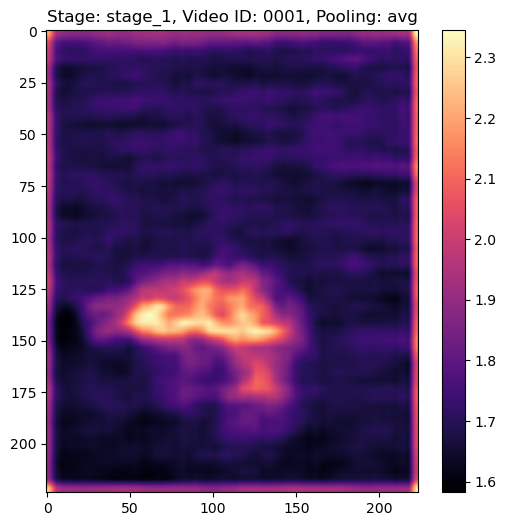

In [21]:
plot_pooled_feature_map(pooled_feature_maps, "stage_1", "0001")